In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output

import os
import sys
sys.path.append("..") 

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

In [ ]:
# Fetch the dataset

RUNNING_ON_COLAB = True

data_path_electrs = '.'
data_path_photons = '.'

# Paths if runninc on colab
if RUNNING_ON_COLAB:
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/gdrive', force_remount=False)

    def_colab_path = '/gdrive/My Drive/Colab Notebooks/CaloGAN/'
    sys.path.append(def_colab_path)

    data_path_electrs = def_colab_path + 'new_data/CaloGAN_e_210000.root.npz'
    data_path_photons = def_colab_path + 'new_data/CaloGAN_gamma_210000.npz'
else:
    # Paths if running locally
    data_path_electrs = './new_data/CaloGAN_e_210000.npz'
    data_path_photons   = './new_data/dataCaloGAN_gamma_210000_val.npz'

# Load data
data_electrs = np.load(data_path_electrs, allow_pickle=False)
#data_photons = np.load(data_path_photons, allow_pickle=False)

Drive not mounted, so nothing to flush and unmount.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
# Import source code

from analysis.calogan_metrics import *
from analysis.prd_score       import *
from analysis.score           import *

from src.data_manipulation  import *
from src.gan_losses         import *
from src.plotting_functions import *
from src.training_procedure import *

In [ ]:
# Set up the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Available device =", device)

Available device = cuda


In [ ]:
TRAIN_IDX = np.arange(0, 100000)
TESTS_IDX = np.arange(100000, 200000)
VALID_IDX = np.arange(200000, 210000)    
NOISE_DIM = 256
BATCH_SIZE = 256

def train_model(data_arr, epoch_num, discriminator, generator, 
                dis_iter_num = 3, 
                gen_iter_num = 1, 
                noise_dim    = NOISE_DIM, 
                loss         = 'WASSERSTEIN',
                batch_size   = BATCH_SIZE, 
                train_idx = TRAIN_IDX, 
                tests_idx = TESTS_IDX, 
                valid_idx = VALID_IDX,
                if_normalise_energies     = False,
                if_rotate_dataset         = False, 
                if_logarithm_energies     = False,
                inv_energy_transformation = None):

    train_dataset, tests_dataset, valid_dataset = get_datasets(data_arr, 
                                                               train_idx, tests_idx, valid_idx,
                                                               rotate_transf      = if_rotate_dataset, 
                                                               normalise_energies = if_normalise_energies,
                                                               logarithm_energies = if_logarithm_energies)

    train_dataloader = utils.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
    #tests_dataloader = utils.DataLoader(tests_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

    #energy_b, mom_b, point_b, pdg_b = valid_dataloader.dataset[8]
    #energy_b = energy_b.reshape((1,1,30,30))
    #plot_energy_and_shower(energy_b, energy_b)

    training = TrainingProcedure(loss, discriminator, generator,
                                 train_dataloader, valid_dataloader,
                                 batch_size, valid_idx.shape[0], device,
                                 dis_iter_num = dis_iter_num, 
                                 gen_iter_num = gen_iter_num, 
                                 noise_dim = noise_dim, 
                                 loss = loss, 
                                 INSTANCE_NOISE = INSTANCE_NOISE,
                                 inv_energy_transformation = inv_energy_transformation)
    training.run(epoch_num, True)
    return training, training.best_models

def save_generator(generator, filename, noise_dim=30):
    generator_cpu = Generator(z_dim=noise_dim)
    generator_cpu.load_state_dict(generator.state_dict())
    generator_cpu.eval()

    # Save the trained model on google disk
    torch.save(generator_cpu.state_dict(), def_colab_path + filename)
    print('The model is saved to', def_colab_path + filename)
    return

def continous_training(total_epoch_num, filename, noise_dim, if_save_generator=False, generator_fname=""):
    new_tr_class = None

    with open(def_colab_path + filename, 'rb') as pickle_file:
        new_tr_class = pickle.load(pickle_file)

    new_tr_class.run(total_epoch_num, True)

    with open(def_colab_path + filename, 'wb') as pickle_file:
        pickle.dump(new_tr_class, pickle_file)
    
    if if_save_generator:
        save_generator(new_tr_class.generator, generator_fname, noise_dim)

    del new_tr_class
    return

In [ ]:
print(torch.__version__)

1.6.0+cu101


In [ ]:
from torch.nn.utils import spectral_norm

class Generator(nn.Module):
    def __init__(self, z_dim, act_func = F.relu):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.activation = act_func

        # 128 + 5 -> (+reshape) 128 x 2 x 2
        self.fc1 = nn.Linear(self.z_dim + 5, self.z_dim * 2 * 2)

        # Z x 2 x 2
        self.conv1 = nn.ConvTranspose2d(self.z_dim, 128, 3, stride=2, padding=1, output_padding=1) 
        # 128 x 8 x 8
        self.conv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        # 64 x 16 x 16
        self.conv3 = nn.ConvTranspose2d(64, 32,  3, stride=2, padding=1, output_padding=1)
        # 32 x 32 x 32
        self.conv4 = nn.ConvTranspose2d(32, 1,  3, stride=2, padding=1, output_padding=1)
        # 1 x 32 x 32
        # crop
        # 1 x 30 x 30

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)

    def forward(self, z, ParticleMomentum_ParticlePoint):
        x = torch.cat([z, ParticleMomentum_ParticlePoint], dim=1)
        #print(x.shape)
        x = F.leaky_relu(self.fc1(x))

        #print(x.shape)
        EnergyDeposit = x.view(-1, self.z_dim, 2, 2)

        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn1(self.conv1(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn2(self.conv2(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.bn3(self.conv3(EnergyDeposit)))
        #print(EnergyDeposit.shape)
        EnergyDeposit = self.activation(self.conv4(EnergyDeposit))
        #print(EnergyDeposit.shape)
        EnergyDeposit = EnergyDeposit[:,:,1:31,1:31]
        #print(EnergyDeposit.shape)
                
        return EnergyDeposit


class Discriminator(nn.Module):
    def __init__(self, act_func = F.leaky_relu):
        super(Discriminator, self).__init__()
        self.activation = act_func

        # 30x30x1 -> 32x32x1 (padding)
        # 32x32x1
        self.conv1 = nn.Conv2d( 1,   32, 3, stride=2, padding=1)
        # 16x16x32
        self.conv2 = nn.Conv2d( 32,  64, 3, stride=2, padding=0)
        # 8x8x64
        self.conv3 = nn.Conv2d( 64, 128, 3, stride=2, padding=0)
        # 2x2x256
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=0)
        # 1x1x256
        self.conv5 = nn.Conv2d(256, 256, 3, stride=2, padding=0)

        # 5x5x256 = 6400
        self.fc1 = nn.Linear(256 + 5, 64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,1)
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        #print(EnergyDeposit.shape)
        X = self.activation(self.conv1(EnergyDeposit))
        #print(X.shape)
        X = self.activation(self.conv2(X))
        #print(X.shape)
        X = self.activation(self.conv3(X))
        #print(X.shape)
        X = self.activation(self.conv4(X))
        #print(X.shape)

        X = X.reshape(-1,256)
        #print(X.shape)
        X = torch.cat([X, ParticleMomentum_ParticlePoint], dim=1)
        #print(X.shape)
        
        X = F.leaky_relu(self.fc1(X))
        #print(X.shape)
        X = F.leaky_relu(self.fc2(X))
        #print(X.shape)

        if TASK in ['WASSERSTEIN', 'HINGE']:
            return self.fc3(X)
        else:
            return torch.sigmoid(self.fc3(X))

In [ ]:
INITIAL_EPOCHS = 20

Epoch #19
Mean discriminator output on real data = -34.724
Mean discriminator output on generated data = -29.3716


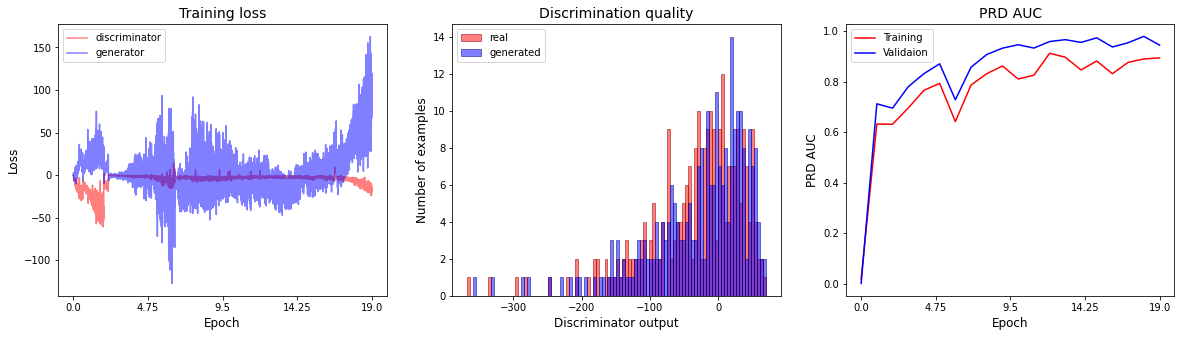

100%|██████████| 20/20 [2:27:49<00:00, 443.49s/it]


In [ ]:
TRAIN_CLASS_FNAME = 'sep-7-logE.pt'

 # check if file exists to prevent overwriting
if os.path.isfile(def_colab_path + TRAIN_CLASS_FNAME) == False:
    tr_class, pos_gen_models = train_model(data_electrs,
                                           INITIAL_EPOCHS, 
                                           discriminator = Discriminator(), 
                                           generator = Generator(NOISE_DIM),
                                           dis_iter_num = 3, 
                                           gen_iter_num = 1,
                                           if_logarithm_energies=True,
                                           inv_energy_transformation=inv_log_energy)
    
    with open(def_colab_path + TRAIN_CLASS_FNAME, 'wb') as pickle_file:
        pickle.dump(tr_class, pickle_file)

    del tr_class

Epoch #32
Mean discriminator output on real data = -97.139
Mean discriminator output on generated data = -97.66


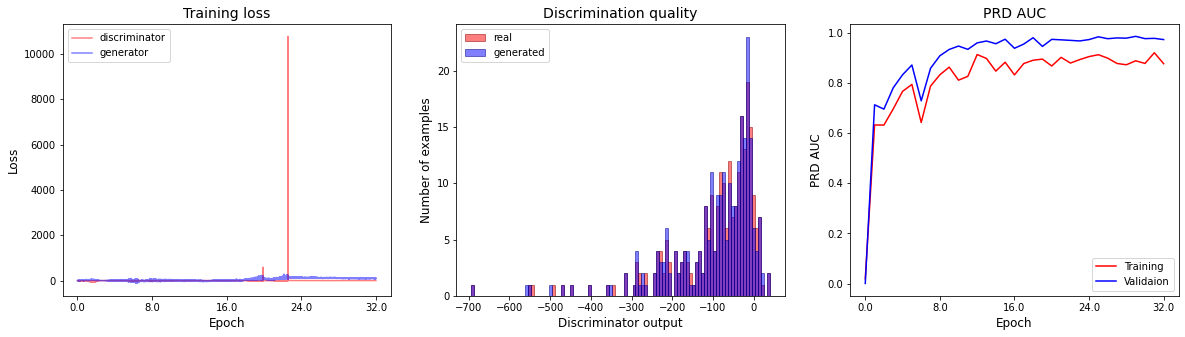

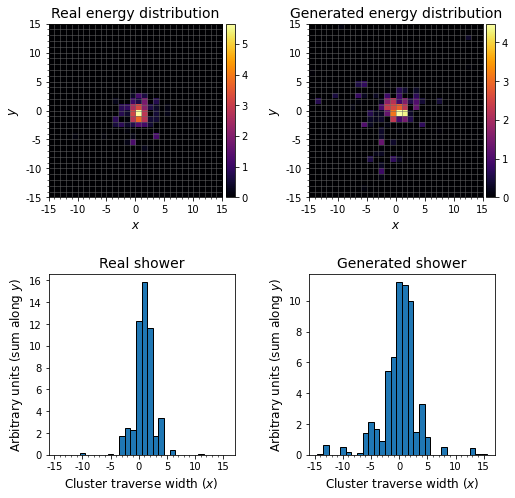

 16%|█▋        | 13/80 [1:35:44<8:13:29, 441.94s/it]

transformation
transformation


In [ ]:
continous_training(100, TRAIN_CLASS_FNAME, NOISE_DIM)

Epoch #19
Mean discriminator output on real data = 31547.6
Mean discriminator output on generated data = 8581.77


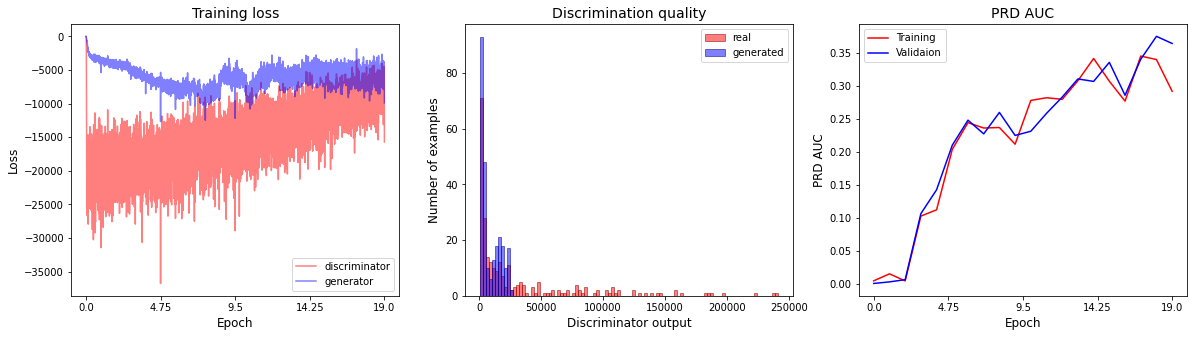

100%|██████████| 20/20 [43:54<00:00, 131.70s/it]


In [ ]:
TRAIN_CLASS_FNAME = 'sep-6-E.pt'

 # check if file exists to prevent overwriting
if os.path.isfile(def_colab_path + TRAIN_CLASS_FNAME) == False:
    tr_class, pos_gen_models = train_model(data_electrs,
                                           INITIAL_EPOCHS, 
                                           discriminator = Discriminator(), 
                                           generator = Generator(NOISE_DIM),
                                           dis_iter_num = 2, 
                                           gen_iter_num = 1)
    
    with open(def_colab_path + TRAIN_CLASS_FNAME, 'wb') as pickle_file:
        pickle.dump(tr_class, pickle_file)

    del tr_class

Epoch #99
Mean discriminator output on real data = -6559.8
Mean discriminator output on generated data = -6704.09


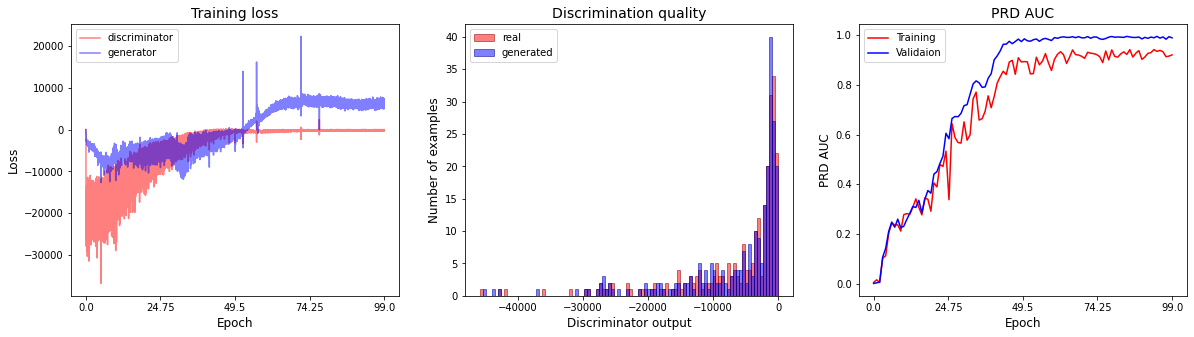

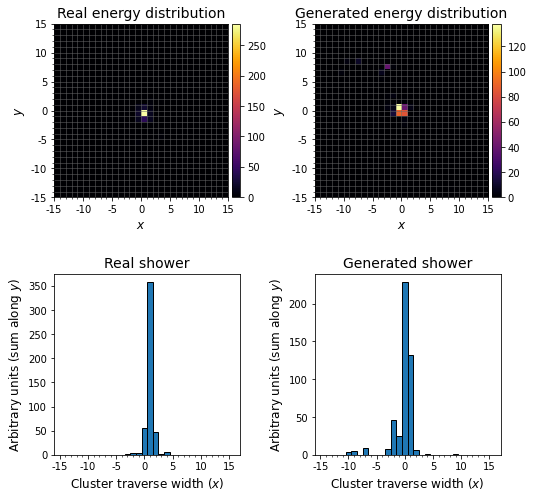

100%|██████████| 25/25 [56:30<00:00, 135.61s/it]


In [ ]:
continous_training(100, TRAIN_CLASS_FNAME, NOISE_DIM)